Apply XGBoost classification algorithm on the loan data set and compare its performance with Logistic Regression by suitably splitting the data into train and test sets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb

In [2]:
asg_loan_df = pd.read_excel('loan.xlsx')

In [3]:
asg_loan_df.head()

,Sex,Age,Time_at_address,Res_status,Telephone,Occupation,Job_status,Time_employed,Time_bank,Liab_ref,Acc_ref,Home_Expn,Balance,Decision
0,M,50.750000,0.585,owner,given,unemploye,unemploye,0,0,f,given,145,0,reject
1,M,19.670000,10.000,rent,not_given,labourer,governmen,0,0,t,given,140,0,reject
2,F,52.830002,15.000,owner,given,creative_,private_s,5,14,f,given,0,2200,accept
3,M,22.670000,2.540,rent,not_given,creative_,governmen,2,0,f,given,0,0,accept
4,M,29.250000,13.000,owner,given,driver,governmen,0,0,f,given,228,0,reject


In [4]:
df = pd.get_dummies(asg_loan_df, drop_first=True)

In [5]:
df.head()

,Age,Time_at_address,Time_employed,Time_bank,Home_Expn,Balance,Sex_M,Res_status_rent,Telephone_not_given,Occupation_driver,...,Occupation_unemploye,Job_status_military,Job_status_private_s,Job_status_retired,Job_status_self_empl,Job_status_student,Job_status_unemploye,Liab_ref_t,Acc_ref_oth_inst_,Decision_reject
0,50.750000,0.585,0,0,145,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,19.670000,10.000,0,0,140,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
2,52.830002,15.000,5,14,0,2200,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,22.670000,2.540,2,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,29.250000,13.000,0,0,228,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


**Exploratory analysis on the loan dataset**

In [6]:
asg_loan_df.shape

(429, 14)

In [7]:
asg_loan_df['Decision'].value_counts()

reject    237
accept    192
Name: Decision, dtype: int64

In [8]:
print('Percentage distribution')
asg_loan_df['Decision'].value_counts()/float(len(asg_loan_df))

Percentage distribution


reject    0.552448
accept    0.447552
Name: Decision, dtype: float64

<AxesSubplot:xlabel='Decision', ylabel='count'>

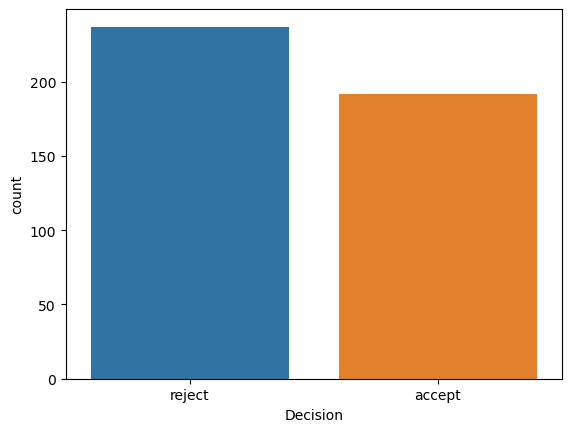

In [9]:
sns.countplot(x='Decision', data=asg_loan_df)

In [10]:
asg_loan_df.isnull().sum()

Sex                0
Age                0
Time_at_address    0
Res_status         0
Telephone          0
Occupation         0
Job_status         0
Time_employed      0
Time_bank          0
Liab_ref           0
Acc_ref            0
Home_Expn          0
Balance            0
Decision           0
dtype: int64

**Performing correlation analysis on the numerical and categorical columns**

In [11]:
loan_df_copy = asg_loan_df.copy()
numerical_cols = loan_df_copy[['Age', 'Time_at_address', 'Time_employed', 'Time_bank', 'Home_Expn', 'Balance']]
categorical_cols = loan_df_copy.drop(columns=['Age', 'Time_at_address', 'Time_employed', 'Time_bank', 'Home_Expn', 'Balance'])

#Performing one hot encoding to get the categorical columns to respective continuous values.

#Column Name: Sex
Sex = pd.get_dummies(loan_df_copy['Sex'], drop_first=True, prefix='sex')
#Column Name: Res_status
Res_status = pd.get_dummies(loan_df_copy['Res_status'], drop_first=True, prefix='res_status')
#Column Name: Telephone
Telephone = pd.get_dummies(loan_df_copy['Telephone'], drop_first=True, prefix='telephone')
#Column Name: Occupation
Occupation = pd.get_dummies(loan_df_copy['Occupation'], drop_first=True, prefix='occupation')
#Column Name:Job_status
Job_status = pd.get_dummies(loan_df_copy['Job_status'], drop_first=True, prefix='job_status')
#Column Name: Liab_ref
Liab_ref = pd.get_dummies(loan_df_copy['Liab_ref'], drop_first=True, prefix='liab_ref')
#Column Name: Acc_ref
Acc_ref = pd.get_dummies(loan_df_copy['Acc_ref'], drop_first=True, prefix='acc_ref')
#Column Name: Decision
Decision =  pd.get_dummies(loan_df_copy['Decision'], drop_first=True, prefix='decision')


loan_df_copy.drop(['Sex', 'Res_status', 'Telephone', 'Occupation', 'Job_status', 'Liab_ref', 'Acc_ref', 'Decision'],
                axis=1, inplace=True)

loan_df_copy = pd.concat([loan_df_copy, Sex, Res_status, Telephone, Occupation, Job_status, Liab_ref, Acc_ref, Decision],
                       axis=1)

loan_df_copy.columns

loan_df_copy.head()

,Age,Time_at_address,Time_employed,Time_bank,Home_Expn,Balance,sex_M,res_status_rent,telephone_not_given,occupation_driver,...,occupation_unemploye,job_status_military,job_status_private_s,job_status_retired,job_status_self_empl,job_status_student,job_status_unemploye,liab_ref_t,acc_ref_oth_inst_,decision_reject
0,50.750000,0.585,0,0,145,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
1,19.670000,10.000,0,0,140,0,1,1,1,0,...,0,0,0,0,0,0,0,1,0,1
2,52.830002,15.000,5,14,0,2200,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,22.670000,2.540,2,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,29.250000,13.000,0,0,228,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [12]:
loan_df_copy_reject = loan_df_copy[loan_df_copy.decision_reject == 1]
loan_df_copy_accept = loan_df_copy[loan_df_copy.decision_reject == 0]

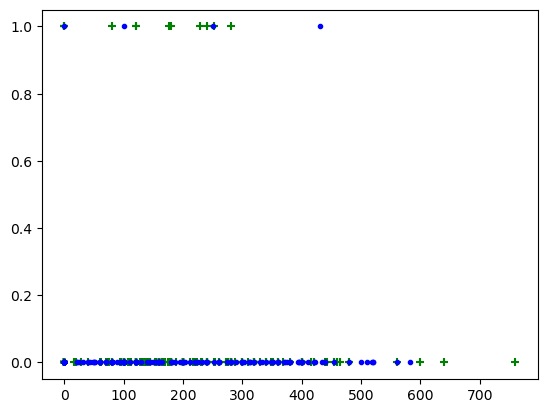

In [13]:
plt.scatter(loan_df_copy_reject['Home_Expn'], loan_df_copy_reject['occupation_driver'], color="green", marker='+')
plt.scatter(loan_df_copy_accept['Home_Expn'], loan_df_copy_accept['occupation_driver'], color="blue", marker='.')

**Correlation plot between the columns in the dataframe**

**Splitting the dataset into train and test data**

In [14]:
X = loan_df_copy.drop(columns='decision_reject')
y = loan_df_copy['decision_reject']

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
# model = xgb.XGBClassifier(
#     learning_rate=0.1,
#     max_depth=5,
#     n_estimators=100,
#     verbosity=1
# )

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr'
)

In [18]:
model.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.78933
[1]	validation_0-aucpr:0.80483
[2]	validation_0-aucpr:0.80592
[3]	validation_0-aucpr:0.85562
[4]	validation_0-aucpr:0.82356
[5]	validation_0-aucpr:0.86468
[6]	validation_0-aucpr:0.84338
[7]	validation_0-aucpr:0.86613
[8]	validation_0-aucpr:0.85326
[9]	validation_0-aucpr:0.85355
[10]	validation_0-aucpr:0.85390
[11]	validation_0-aucpr:0.84225
[12]	validation_0-aucpr:0.85975
[13]	validation_0-aucpr:0.85657
[14]	validation_0-aucpr:0.86143
[15]	validation_0-aucpr:0.86636
[16]	validation_0-aucpr:0.86342
[17]	validation_0-aucpr:0.86919
[18]	validation_0-aucpr:0.86637
[19]	validation_0-aucpr:0.86826
[20]	validation_0-aucpr:0.87262
[21]	validation_0-aucpr:0.87625
[22]	validation_0-aucpr:0.87513
[23]	validation_0-aucpr:0.87553
[24]	validation_0-aucpr:0.87380
[25]	validation_0-aucpr:0.87290
[26]	validation_0-aucpr:0.86784
[27]	validation_0-aucpr:0.87114
[28]	validation_0-aucpr:0.86932
[29]	validation_0-aucpr:0.86896
[30]	validation_0-aucpr:0.86837


C:\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [19]:
from sklearn.metrics import plot_confusion_matrix

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


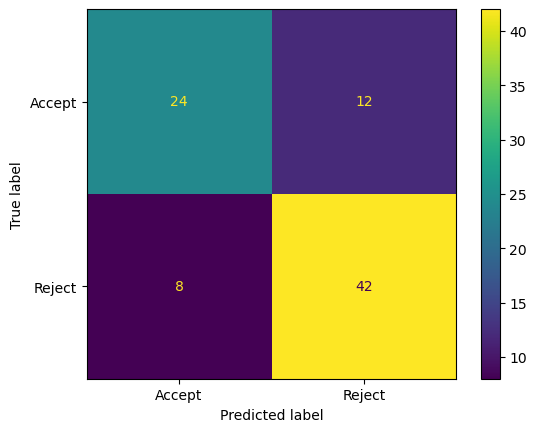

In [20]:
plot_confusion_matrix(
    model,
    X_test,
    y_test,
    display_labels=['Accept', 'Reject']
)

In [21]:
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    gamma=0.25,
    learn_rate=0.1,
    reg_lambda=10,
    scale_pos_weight=3,
    subsample=0.9,
    colsample_bytree=0.5,
    early_stopping_rounds=10,
#     n_estimators=20,
)

In [22]:
model.fit(X_train, y_train, verbose=True, eval_set=[(X_test, y_test)])

[18:42:44] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "learn_rate" } are not used.

[0]	validation_0-aucpr:0.73951
[1]	validation_0-aucpr:0.89429
[2]	validation_0-aucpr:0.87391
[3]	validation_0-aucpr:0.86442
[4]	validation_0-aucpr:0.85185
[5]	validation_0-aucpr:0.83509
[6]	validation_0-aucpr:0.84807
[7]	validation_0-aucpr:0.87882
[8]	validation_0-aucpr:0.88961
[9]	validation_0-aucpr:0.87840
[10]	validation_0-aucpr:0.87764
[11]	validation_0-aucpr:0.89983
[12]	validation_0-aucpr:0.90479
[13]	validation_0-aucpr:0.89770
[14]	validation_0-aucpr:0.89280
[15]	validation_0-aucpr:0.89262
[16]	validation_0-aucpr:0.87455
[17]	validation_0-aucpr:0.87836
[18]	validation_0-aucpr:0.87478
[19]	validation_0-aucpr:0.86774
[20]	validation_0-aucpr:0.87528
[21]	validation_0-aucpr:0.86634


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learn_rate=0.1, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


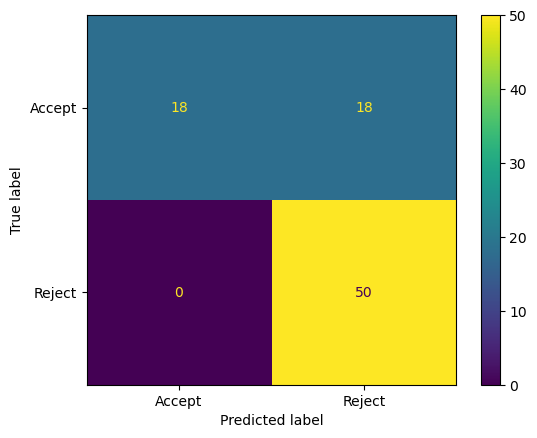

In [23]:
plot_confusion_matrix(
    model,
    X_test,
    y_test,
    display_labels=['Accept', 'Reject']
)

In [24]:
bst = model.get_booster()

In [65]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',n_estimators = 10, seed = 123)

# Fitting the model
xgb_r.fit(X_train, y_train)

# Predict the model
pred = xgb_r.predict(X_test)

# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred))
print("RMSE : % f" %(rmse))



[19:05:39] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  4.236599


In [25]:
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

weight:  {'Age': 56.0, 'Time_at_address': 38.0, 'Time_employed': 41.0, 'Time_bank': 19.0, 'Home_Expn': 63.0, 'Balance': 38.0, 'sex_M': 6.0, 'res_status_rent': 9.0, 'telephone_not_given': 1.0, 'occupation_guard_etc': 2.0, 'occupation_labourer': 1.0, 'occupation_manager': 5.0, 'occupation_office_st': 6.0, 'occupation_productio': 7.0, 'occupation_professio': 4.0, 'occupation_sales': 4.0, 'occupation_semi_pro': 5.0, 'occupation_unemploye': 2.0, 'job_status_private_s': 5.0, 'job_status_retired': 1.0, 'job_status_self_empl': 5.0, 'job_status_unemploye': 4.0, 'liab_ref_t': 6.0, 'acc_ref_oth_inst_': 6.0}
gain:  {'Age': 1.3058406114578247, 'Time_at_address': 1.2149499654769897, 'Time_employed': 3.0713703632354736, 'Time_bank': 11.330826759338379, 'Home_Expn': 1.6063238382339478, 'Balance': 3.646139144897461, 'sex_M': 0.6420719027519226, 'res_status_rent': 1.5239741802215576, 'telephone_not_given': 0.27766966819763184, 'occupation_guard_etc': 1.1859958171844482, 'occupation_labourer': 0.70583295

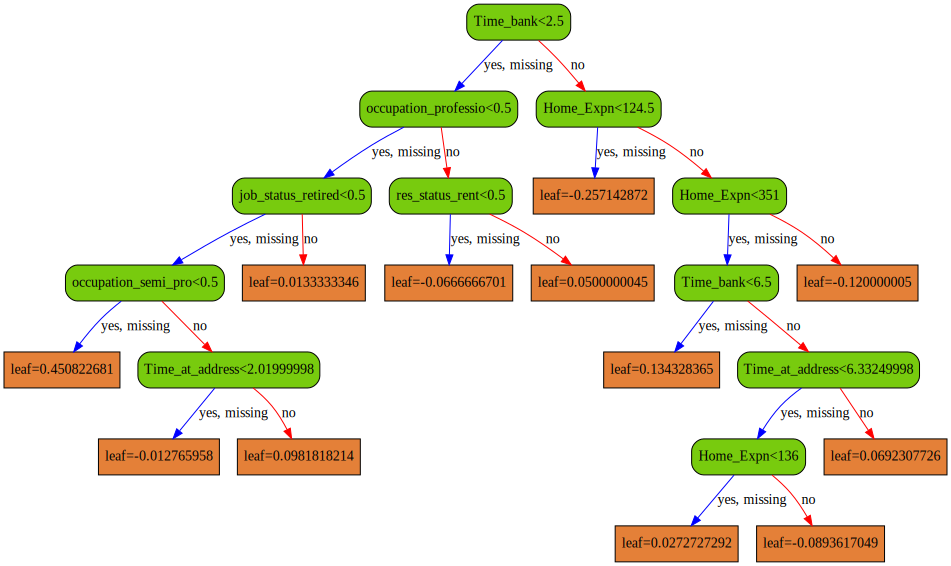

In [26]:
node_params = {'shape': 'box',
              'style': 'filled, rounded',
              'fillcolor': '#78cbe'}
leaf_params = {'shape': 'box',
              'style': 'filled',
              'fillcolor': '#e48038'}

xgb.to_graphviz(model, num_trees=0, size="10,10", condition_node_params=node_params, leaf_node_params=leaf_params)

In [27]:
from sklearn.metrics import classification_report, accuracy_score

**Now we will compare the XGBoost model with Logistic regression**

In [33]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression

model_log_regr = LogisticRegression(max_iter=1000)
model_log_regr.fit(X_train, y_train)

model_log_regr_pred = model_log_regr.predict(X_test)

C:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.92      0.64      0.75        36
           1       0.79      0.96      0.86        50

    accuracy                           0.83        86
   macro avg       0.85      0.80      0.81        86
weighted avg       0.84      0.83      0.82        86

Accuracy: 0.8255813953488372


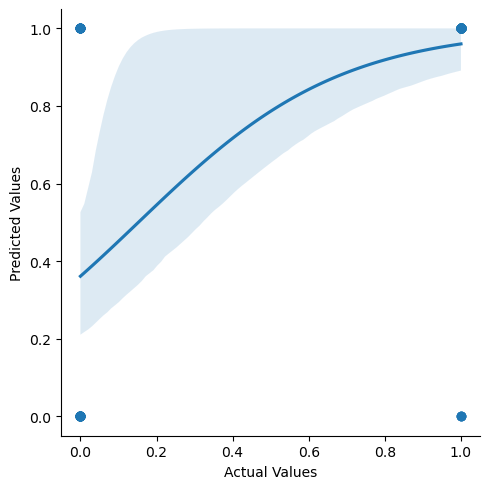

In [34]:
asg_log_pred_df = pd.DataFrame({'Actual Values': y_test, 'Predicted Values': model_log_regr_pred})

sns.lmplot(data=asg_log_pred_df, x='Actual Values', y='Predicted Values', logistic=True)

plt.scatter(x=y_test, y=model_log_regr_pred)

from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_test, model_log_regr_pred))

print('Accuracy:', accuracy_score(y_test, model_log_regr_pred))

xgboost: 0.7906976744186046
svclinear: 0.7790697674418605
svcrbf: 0.6744186046511628
svcpolydeg2: 0.6162790697674418
svcpolydeg3: 0.5930232558139535
svcsigmoid: 0.6976744186046512
logregr: 0.813953488372093


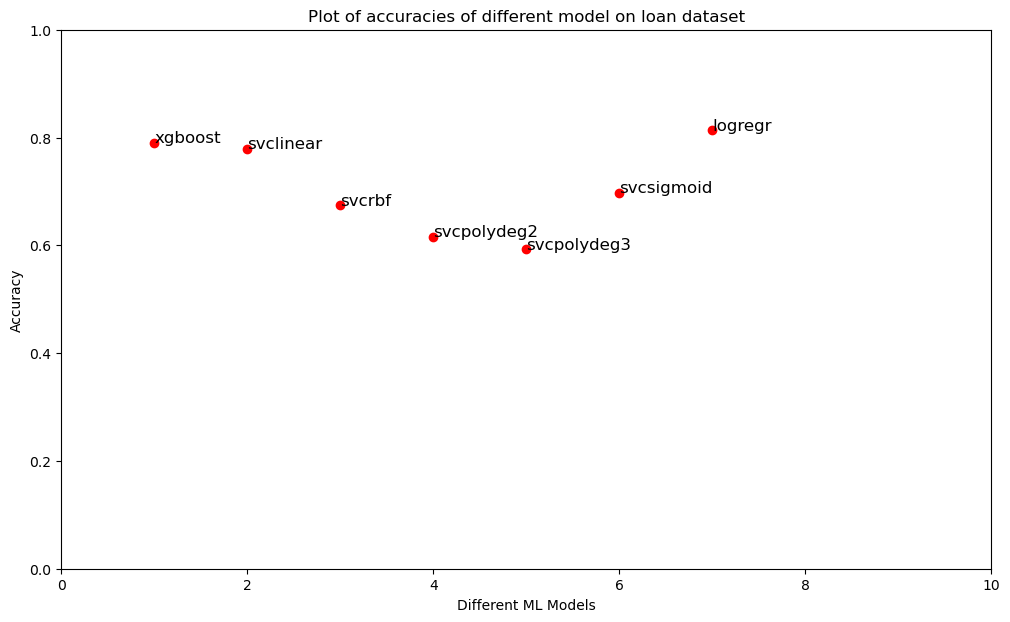

In [35]:
fig, ax = plt.subplots(figsize=(12,7))

ax.set_xlim([0, 10])
ax.set_ylim([0, 1])

models_accuracy_dict = {
    'xgboost': 0.7906976744186046,
    'svclinear': 0.7790697674418605,
    'svcrbf': 0.6744186046511628,
    'svcpolydeg2': 0.6162790697674418,
    'svcpolydeg3': 0.5930232558139535,
    'svcsigmoid': 0.6976744186046512,
    'logregr': 0.813953488372093
}

models_accuracy_df = pd.DataFrame([models_accuracy_dict])

itr = 0;

ax.set_xlabel('Different ML Models')
ax.set_ylabel('Accuracy')
ax.set_title('Plot of accuracies of different model on loan dataset')

for item in models_accuracy_df:
    itr+=1
    print(item + ':', models_accuracy_df[item][0])
    ax.plot(itr, models_accuracy_df[item][0], marker='o', color='red')
    ax.text(itr, models_accuracy_df[item][0], item, size=12)

In [36]:
model_log_regr.coef_.flatten()

array([-6.86356519e-03,  1.73583135e-02, -2.27741973e-01, -3.01902875e-01,
        1.52829713e-03, -3.87203114e-04,  2.45388728e-02,  2.73294718e-01,
        2.73294718e-01,  1.16317003e-01,  2.20976375e-01,  6.01996403e-01,
        5.31136140e-01,  8.00192722e-01, -4.87365142e-01, -2.81190599e-01,
       -1.44353423e+00,  1.29182178e-02, -6.21678875e-01,  1.14966851e+00,
        1.95502148e-01,  1.12503508e-01,  4.76719003e-01, -1.29246725e-01,
       -1.47728953e-01,  1.20303702e+00,  6.78152095e-02, -1.69167234e-01])

In [38]:
feature_importances_log_df = pd.DataFrame({
    'features': list(X_train.columns),
    'model': np.repeat(['logistic'], len(list(X_train.columns))),
    'feature importance': model_log_regr.coef_.flatten(),
})

feature_importances_xgb_df = pd.DataFrame({
    'features': list(X_train.columns),
    'model': np.repeat(['xgboost'], len(list(X_train.columns))),
    'feature importance': model.feature_importances_,
})




feature_importances_df = pd.concat([feature_importances_log_df, feature_importances_xgb_df], ignore_index=True)

feature_importances_df

,features,model,feature importance
0,Age,logistic,-0.006864
1,Time_at_address,logistic,0.017358
2,Time_employed,logistic,-0.227742
3,Time_bank,logistic,-0.301903
4,Home_Expn,logistic,0.001528
5,Balance,logistic,-0.000387
6,sex_M,logistic,0.024539
7,res_status_rent,logistic,0.273295
8,telephone_not_given,logistic,0.273295
9,occupation_driver,logistic,0.116317


**3. Apply XGBoost regression algorithm on the Boston housing data set and compare its performance against Linear regression.**

In [39]:
boston_housing_df = pd.read_excel('boston housing.xls')

In [40]:
boston_housing_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
0,0.00632,18.0,2.31,0,0.538,6.575,65.199997,4.0900,1,296,15.300000,396.899994,4.98,24.000000
1,0.02731,0.0,7.07,0,0.469,6.421,78.900002,4.9671,2,242,17.799999,396.899994,9.14,21.600000
2,0.02729,0.0,7.07,0,0.469,7.185,61.099998,4.9671,2,242,17.799999,392.829987,4.03,34.700001
3,0.03237,0.0,2.18,0,0.458,6.998,45.799999,6.0622,3,222,18.700001,394.630005,2.94,33.400002
4,0.06905,0.0,2.18,0,0.458,7.147,54.200001,6.0622,3,222,18.700001,396.899994,5.33,36.200001


In [41]:
boston_housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CRIM    506 non-null    float64
 1   ZN      506 non-null    float64
 2   INDUS   506 non-null    float64
 3   CHAS    506 non-null    int64  
 4   NOX     506 non-null    float64
 5   RM      506 non-null    float64
 6   AGE     506 non-null    float64
 7   DIS     506 non-null    float64
 8   RAD     506 non-null    int64  
 9   TAX     506 non-null    int64  
 10  PT      506 non-null    float64
 11  B       506 non-null    float64
 12  LSTAT   506 non-null    float64
 13  MV      506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [42]:
boston_housing_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PT,B,LSTAT,MV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674030,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148862,2.105710,8.707259,168.537116,2.164946,91.294863,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377487,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440002,11.360000,21.200001
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.074999,5.188425,24.000000,666.000000,20.200001,396.225006,16.954999,25.000000
max,88.976196,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.899994,37.970001,50.000000


<AxesSubplot:>

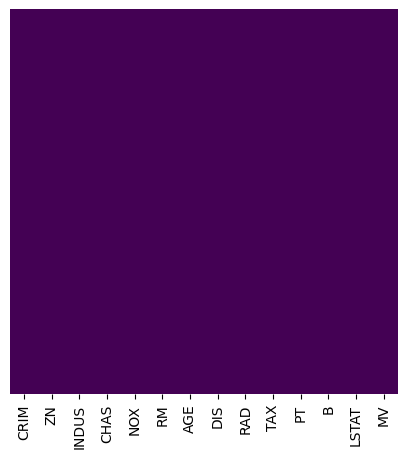

In [43]:
#to check if there are any null values in the dataframe
plt.figure(figsize=(5,5))
sns.heatmap(boston_housing_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

<AxesSubplot:>

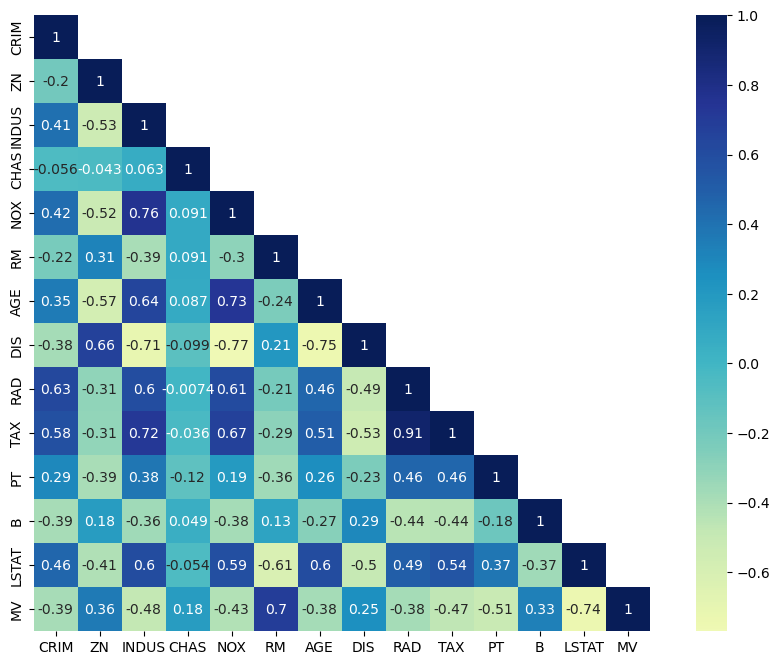

In [44]:
plt.figure(figsize=(12, 8))

mask_upper_triangle = np.triu(np.ones_like(boston_housing_df.corr(), dtype=bool), k=1)

sns.heatmap(boston_housing_df.corr(), cmap="YlGnBu", annot=True, mask=mask_upper_triangle,
            square=True, center = 0 )

In [45]:
from sklearn import linear_model

In [46]:
X_housing = boston_housing_df[['RM', 'ZN', 'B', 'DIS', 'PT', 'LSTAT', 'RAD']]
y_housing = boston_housing_df['MV']

X_train, X_test, y_train, y_test = train_test_split(X_housing, y_housing, train_size=0.3, random_state=0)

regr = linear_model.LinearRegression()

In [47]:
from sklearn.metrics import r2_score

Coefficient:  [ 3.81607162  0.05026324  0.00976733 -1.21503906 -1.0611368  -0.70773502
 -0.02106504]


,Actual Value,Predicted Value,Difference
329,22.600000,26.193108,-3.593107
371,50.000000,25.100583,24.899417
219,23.000000,27.049202,-4.049202
403,8.300000,14.196720,-5.896720
78,21.200001,20.690807,0.509193


<Figure size 1200x1000 with 0 Axes>

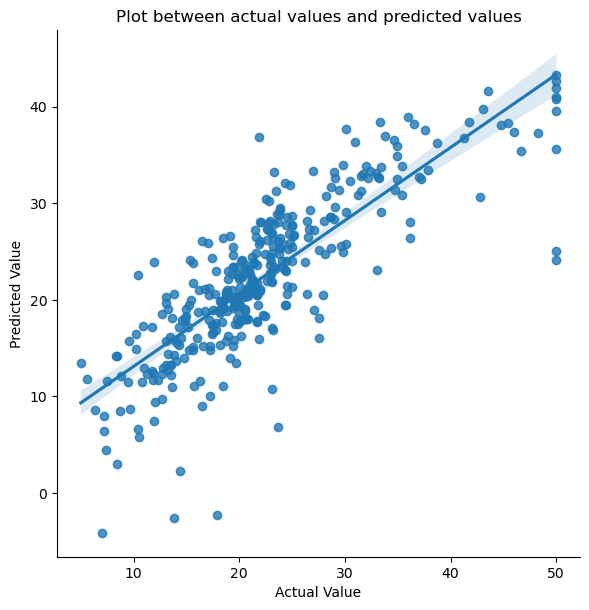

In [48]:
regr.fit(X_train, y_train)

y_pred_housing = regr.predict(X_test)

print('Coefficient: ', regr.coef_)

plt.figure(figsize=(12,10))

y_pred_housing_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred_housing, 
                                  'Difference': y_test - y_pred_housing})

sns.lmplot(x='Actual Value', y='Predicted Value', data=y_pred_housing_df, height=6, aspect=1)
ax = plt.gca()
ax.set_title('Plot between actual values and predicted values')

y_pred_housing_df.head()

In [49]:
import statsmodels.api as sm

In [50]:
X = boston_housing_df[['RM', 'ZN', 'B', 'DIS', 'AGE', 'LSTAT']]
y = boston_housing_df['MV']
model = sm.OLS(y,X)
results = model.fit()
# results.params
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                     MV   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.953
Method:                 Least Squares   F-statistic:                              1725.
Date:                Wed, 22 Feb 2023   Prob (F-statistic):                        0.00
Time:                        18:52:15   Log-Likelihood:                         -1554.5
No. Observations:                 506   AIC:                                      3121.
Df Residuals:                     500   BIC:                                      3146.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**XGB regressor**

In [51]:
regressor = xgb.XGBRegressor()

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [52]:
predictions = regressor.predict(X_test)

In [53]:
from sklearn.metrics import mean_squared_log_error
RMSLE = np.sqrt( mean_squared_log_error(y_test, predictions) )
print("The score is %.5f" % RMSLE )

The score is 0.18736


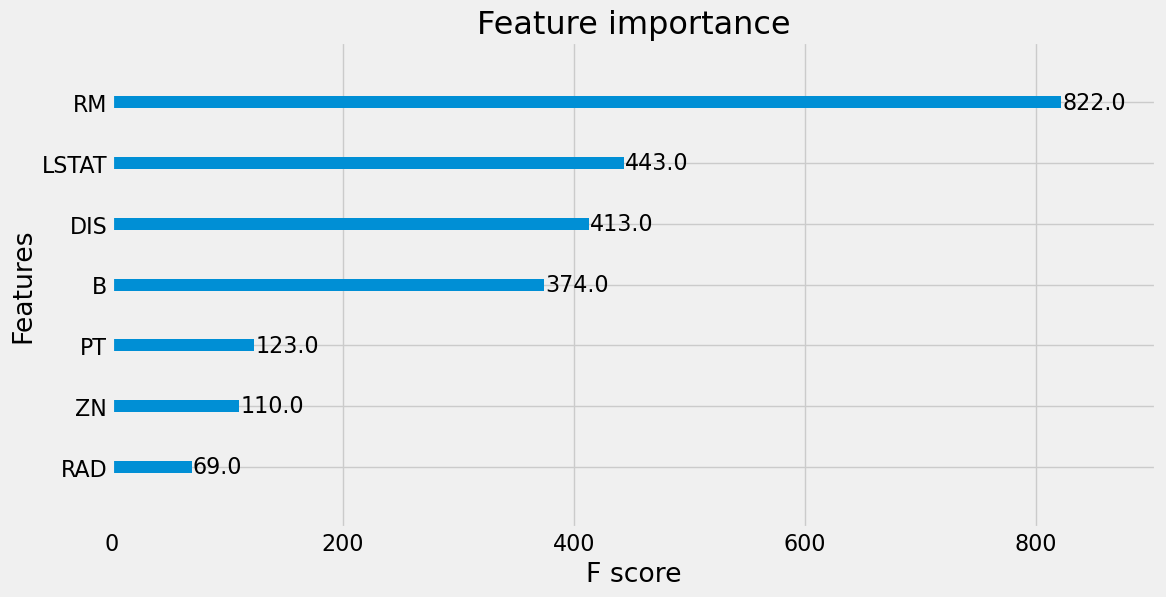

In [54]:
from xgboost import plot_importance

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=8, ax=ax)
plt.show();

**XGBoost algorithm performs better compared to linear regression, we can confirm this with their r-score values.**

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_1 = LinearRegression()
reg_1.fit(X_train, y_train)

y_train_predict = reg_1.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
r2 = round(reg_1.score(X_train, y_train),2)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

The model performance for training set
--------------------------------------
RMSE is 5.051038124290691
R2 score is 0.74




In [69]:
# Predict using test data
pred = xgb_r.predict(X_test)

# Import metrics to evaluate the performance of the XGBoost model
from sklearn import metrics

print('R^2:', metrics.r2_score(y_test, pred))
print('Adjusted R^2:', 1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))


R^2: 0.7695236004759926
Adjusted R^2: 0.7648742206585054
MAE: 2.7150415850689305
MSE: 17.948772290716807
RMSE: 4.236599142085171


XGBoost MSE: 16.133894291381313
Linear Regression MSE: 25.46026586541919


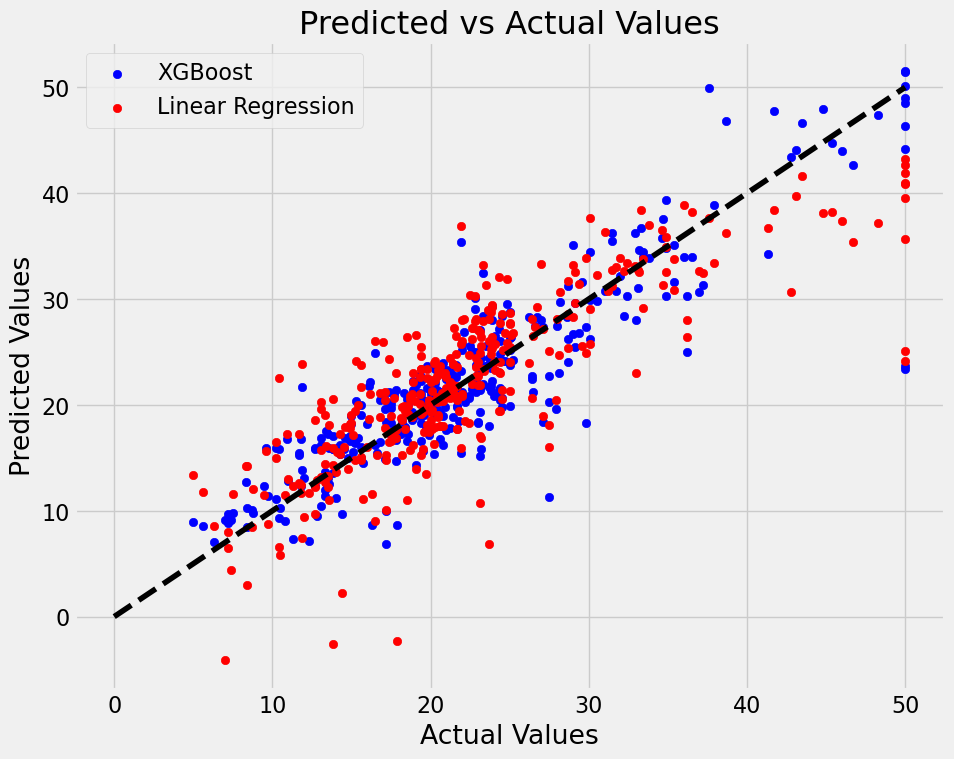

In [71]:
# train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# make predictions on test set
y_test_pred_xgb = xgb_model.predict(X_test)
y_test_pred_lr = lr_model.predict(X_test)

# compute mean squared error on test set
mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)
mse_lr = mean_squared_error(y_test, y_test_pred_lr)

print("XGBoost MSE:", mse_xgb)
print("Linear Regression MSE:", mse_lr)

# plot predicted vs actual values for each model
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(y_test, y_test_pred_xgb, color='blue', label='XGBoost')
ax.scatter(y_test, y_test_pred_lr, color='red', label='Linear Regression')
ax.plot([0, 50], [0, 50], linestyle='--', color='black')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Predicted vs Actual Values')
ax.legend()
plt.show()


**Bias:** The difference between the average prediction of our model and the correct value which we are trying to predict. <br>
High Bias - simplifies model - underfitting <br>
Low Bias - cannot be generalized for future data - overfitting <br>

**Variance:** Variability of model prediction for a given data point or value which tells us spread of our data. <br>
High Variance - pays a lot of attention to training data & does not generalize for data which it hasn't seen. <br>
Low Variance - underfitting<br>

The trade off: If our model is too simple with less parameters then we are underfitting which is **high bias** and **low variance**, and if we our model is complicated with many features then we are overfitting which is **low bias** and **high variance**. Hence we should find an optimal balance between the model complexity and the number of parameters.

**Bagging:** Bagging is an ensemble machine learning technique, in which the data is divided into several smaller sample subsets and each subset is fed to a model and the output from all individual model is taken, then a majority vote is taken for the final output. <br>
This resampling of the dataset is done with replacement and it is called bootstrap, and then aggregating the model outputs is called aggregation.<br>

**Boosting:** It is a process that uses a set of ML algorithms to combine weak learners to form strong learners in order to increase the accuracy of the model.<br>
Types of boosting:
1. Adaptive boosting
2. Gradient boosting
3. Extreme gradient bosting (XGBoost)

**Ensemble approach:** It is an approach that is used to enhance the performance of ML model by combining several learners.

**Model complexity:** It is a measure of with how much accuracy a model can predict the output for the data it has not seen before, also how much data it needs to be able to predict the output values with good accuracy.

**XGBoost algorithm:** It is a gradient boosting algorithm(ensemble method - predicts by combining predictions from several models into one - uses gradient descent algorithm to minimize the loss function) which uses decision trees as its weak predictors. And on top of that it is built for computation speed and performance.